<img src="https://raw.githubusercontent.com/CameronLarsonFLT/FP_Design_Random_Forest/main/RF_SDL.png" width="400" align="right">

##FP Property Prediction and Design using Random Forest

> **Example script** demonstrating how to:
- Retrieve fluorescent protein (FP) data from the **FPbase API**
- Train RandomForest Regressor **(Scikit-Learn)**
- Predict key **spectral / photophysical properties** from an **amino-acid sequence**

**Inputs:** `protein sequence (AA)`  
**Outputs:** `ex_max`, `em_max`, `brightness`, `pKa`, `stokes_shift`

In [ ]:
#@title ### Model / Design Parameters

#@markdown **Target property**
var = "brightness"  #@param ["brightness", "ex_max", "em_max", "stokes_shift"]

#@markdown **Template sequence variable name (must exist in notebook)**
template_name = "EGFP"  #@param {type:"string"}


#@markdown **Dataset selection**
data_selection = "Aequoria"  #@param ["Aequoria", "Discosoma", "Entacmaea", "Synthetic", "All"]

# ----------------------------
# Resolve species → taxonomy ID
# ----------------------------
SPECIES_TO_TAXID = {
    "Aequoria": 6100,
    "Discosoma": 86600,
    "Entacmaea": 6118,
    "Synthetic":32630,
    "All": None,   # special case: use all species
}

tax_id = SPECIES_TO_TAXID[data_selection]

print(f"Selected dataset: {data_selection}")
print(f"Resolved taxonomy ID: {tax_id}")

#@markdown **Template sequence (Remove Valine at Position 2 for Accuracy)**
current_seq = 'MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLTYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITLGMDELYK' #@param {type:"string"}

# Alias for clarity downstream
template = current_seq


#@markdown **Select Number of Runs for Model Interrogation**
N_RUNS = 3  #@param {type:"integer"}


Selected dataset: Aequoria
Resolved taxonomy ID: 6100


In [ ]:
#@markdown ---
#@markdown # Retrieve and Clean Sequences - *Remove Valine*
#@markdown ---

import requests
import random
import requests
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

import requests

proteins = []

if tax_id is None:
    print("Using ALL FPbase proteins")
    url = "https://www.fpbase.org/api/proteins/?format=json"
else:
    print(f"Filtering FPbase by taxonomy ID {tax_id}")
    url = f"https://www.fpbase.org/api/proteins/?parent_organism={tax_id}&format=json"


while url:
    response = requests.get(url)
    response.raise_for_status()
    data = response.json()

    if isinstance(data, list):
        proteins.extend(data)
        break
    else:
        proteins.extend(data.get("results", []))
        url = data.get("next")

# Remove channelrhodopsins + similar constructs
exclude_terms = ('channelrhodopsin', 'rcamp', 'gcamp2', 'cp-mkate', 'cegfp')

cleaned_proteins = []

for p in proteins:
    name = (p.get("name") or "").lower()
    if any(term in name for term in exclude_terms):
        continue

    seq = p.get("seq")
    if not seq or len(seq) < 2:
        continue

    # Remove Valine at position 2 if present
    if seq[1] == "V":
        seq = seq[0] + seq[2:]

    p["seq"] = seq

    # -------------------
    # Compute Stokes shift
    # -------------------
    p["stokes_shift"] = None

    for state in p.get("states", []) or []:
        ex_max = state.get("ex_max")
        em_max = state.get("em_max")

        if ex_max is not None and em_max is not None:
            try:
                shift = float(em_max) - float(ex_max)
            except Exception:
                shift = None

            state["stokes_shift"] = shift
            p["stokes_shift"] = shift
            break  # first valid state only

    cleaned_proteins.append(p)

proteins = cleaned_proteins

print(f"Proteins after cleanup: {len(proteins)}")

# Optional sanity check
assert all(p["seq"][1] != "V" for p in proteins if len(p["seq"]) > 1)
print(" No Valine remains at position 2")

# Step 2: Extract sequences and target values (based on `var`)
seqs, target_vals = [], []

for entry in proteins:
    seq = entry.get("seq")
    if not seq:
        continue

    # Where the property lives depends on var
    if var == "stokes_shift":
        target = entry.get("stokes_shift", None)  # protein-level (you computed this)
    else:
        states = entry.get("states", [])
        target = None
        if states and isinstance(states, list):
            target = states[0].get(var)

    # Keep only usable numeric values
    if target is None:
        continue
    try:
        target = float(target)
    except Exception:
        continue

    seqs.append(seq)
    target_vals.append(target)

print(f"Usable samples for {var}: {len(seqs)}")

# Build one-hot encoding vocab (match your other scripts)
aa_alphabet = "ACDEFGHIKLMNPQRSTVWY"
aa_index = {aa: i for i, aa in enumerate(aa_alphabet)}

# Max length from the extracted sequences (keeps consistent feature length)
max_len = max(len(s) for s in seqs)
print(f"Max sequence length: {max_len}")

def one_hot_encode(seq, max_len):
    arr = np.zeros((max_len, len(aa_alphabet)), dtype=np.float32)
    for i, aa in enumerate(seq[:max_len]):
        idx = aa_index.get(aa)
        if idx is not None:
            arr[i, idx] = 1.0
    return arr.flatten()

X = np.array([one_hot_encode(seq, max_len) for seq in seqs], dtype=np.float32)
y = np.array(target_vals, dtype=np.float32)

print("X shape:", X.shape, "| y shape:", y.shape)



Filtering FPbase by taxonomy ID 6100
Proteins after cleanup: 286
 No Valine remains at position 2
Usable samples for brightness: 148
Max sequence length: 353
X shape: (148, 7060) | y shape: (148,)


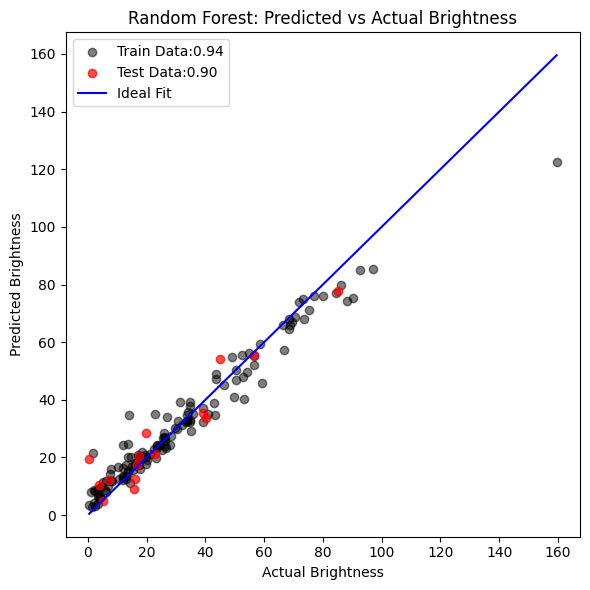

In [ ]:
#@markdown ---
#@markdown # Model Visualization - *Train Test Split*
#@markdown ---
import matplotlib.pyplot as plt
import numpy as np

# Assume X, y, proteins, etc. are already defined as in your script

# Split and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=None)
model = RandomForestRegressor(n_estimators=100, random_state=None)
model.fit(X_train, y_train)

# Predictions
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)


# Plot
plt.figure(figsize=(6, 6), facecolor='white')

# Plot training data
plt.scatter(y_train, y_pred_train, color='black', alpha=0.5, label=f'Train Data:{r2_train:.2f}')

# Plot test data
plt.scatter(y_test, y_pred_test, color='red', alpha=0.7, label=f'Test Data:{r2_test:.2f}')

# Ideal fit line
all_y = np.concatenate([y_train, y_test])
plt.plot([min(all_y), max(all_y)], [min(all_y), max(all_y)], color='blue', label='Ideal Fit')


# Labels and styling
plt.xlabel(f'Actual {var.title()}')
plt.ylabel(f'Predicted {var.title()}')
plt.title(f'Random Forest: Predicted vs Actual {var.title()}')
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()


In [ ]:

#@markdown ---
#@markdown #Interrogate Model using Multiple Runs *(Will Take ~10 minutes to Interrogate 3x)*
#@markdown ---

import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# ----------------------------
# Load & prepare dataset
# ----------------------------
seqs, brightness_vals = [], []

for entry in proteins:
    seq = entry.get("seq")
    states = entry.get("states", [])
    val = None
    if states and isinstance(states, list):
        val = states[0].get(var)

    if seq and val is not None:
        try:
            seqs.append(seq)
            brightness_vals.append(float(val))
        except Exception:
            pass

print(f"Total usable sequences: {len(seqs)}")

# Define amino acid properties
max_len = 238
aa_alphabet = 'ACDEFGHIKLMNPQRSTVWY'
aa_index = {aa: i for i, aa in enumerate(aa_alphabet)}

def one_hot_encode(seq, max_len):
    arr = np.zeros((max_len, len(aa_alphabet)), dtype=np.float32)
    for i, aa in enumerate(seq[:max_len]):
        idx = aa_index.get(aa)
        if idx is not None:
            arr[i, idx] = 1.0
    return arr.flatten()

# Encode input sequences
X = np.array([one_hot_encode(seq, max_len) for seq in seqs], dtype=np.float32)
y = np.array(brightness_vals, dtype=np.float32)

# ----------------------------
# 5 runs: split -> train -> interrogate
# ----------------------------
N_RUNS = N_RUNS
TEST_SIZE = 0.1
N_ESTIMATORS = 100

# We will accumulate mutation predictions in a fixed array:
# shape = (n_positions, 20 AAs, n_runs)
template_len = len(template)
aa_list = list(aa_alphabet)
aa_to_col = {aa: j for j, aa in enumerate(aa_list)}

pred_cube = np.zeros((template_len, len(aa_list), N_RUNS), dtype=np.float32)

# Track per-run performance on its own test split
run_metrics = []

# Use different random_state each run so splits differ
# BASE_SEED = int(time.time_ns() % (2**31 - 1))   # changes each execution

# rng = np.random.default_rng(BASE_SEED)
# seeds = rng.integers(0, 2**31 - 1, size=N_RUNS)

for run_i in range(N_RUNS):
    # Train/test split (different each run)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=None
    )

    # Train RF (also vary model seed so forests differ too)
    model = RandomForestRegressor(
        n_estimators=N_ESTIMATORS,
        random_state=None,
        n_jobs=-1
    )
    model.fit(X_train, y_train)

    # Evaluate
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    run_metrics.append((mae, r2))

    print(f"[Run {run_i+1}/{N_RUNS}] | MAE={mae:.2f} | R²={r2:.2f}")

    # Interrogate all positions × all AAs for this run
    # Efficiently reuse list(template)
    base = list(template)

    for pos in range(template_len):
        original_aa = base[pos]

        for new_aa in aa_list:
            # OPTIONAL: skip identity (keeps only true mutations)
            # if new_aa == original_aa:
            #     continue

            mutated = base.copy()
            mutated[pos] = new_aa
            mutated_seq = ''.join(mutated)

            encoded = one_hot_encode(mutated_seq, max_len).reshape(1, -1)
            pred_val = float(model.predict(encoded)[0])

            pred_cube[pos, aa_to_col[new_aa], run_i] = pred_val

# Summarize overall performance
maes = [m[0] for m in run_metrics]
r2s = [m[1] for m in run_metrics]
print("\nAcross runs:")
print(f"  MAE: mean={np.mean(maes):.2f} ± {np.std(maes):.2f}")
print(f"  R² : mean={np.mean(r2s):.2f} ± {np.std(r2s):.2f}")

# ----------------------------
# Average (and std) across runs
# ----------------------------
avg_mat = pred_cube.mean(axis=2)   # (positions, AAs)
std_mat = pred_cube.std(axis=2)    # (positions, AAs)

# Build avg_mutant_predictions dict (matches your old style keys)
avg_mutant_predictions = {}
std_mutant_predictions = {}

for pos0 in range(template_len):
    original_aa = template[pos0]
    site = pos0 + 1
    for aa in aa_list:
        label = f"{original_aa}{site}{aa}"
        avg_mutant_predictions[label] = float(avg_mat[pos0, aa_to_col[aa]])
        std_mutant_predictions[label] = float(std_mat[pos0, aa_to_col[aa]])


# ----------------------------
# Heatmap from averaged predictions
# ----------------------------
site_order = list(range(1, template_len + 1))
df_avg = pd.DataFrame(index=site_order, columns=aa_list, dtype=float)
df_std = pd.DataFrame(index=site_order, columns=aa_list, dtype=float)

for pos0 in range(template_len):
    site = pos0 + 1
    for aa in aa_list:
        df_avg.loc[site, aa] = avg_mat[pos0, aa_to_col[aa]]
        df_std.loc[site, aa] = std_mat[pos0, aa_to_col[aa]]

print("Avg matrix shape (sites × AA):", df_avg.shape)




Total usable sequences: 148
[Run 1/3] | MAE=8.11 | R²=0.64
[Run 2/3] | MAE=6.77 | R²=0.85
[Run 3/3] | MAE=9.46 | R²=0.19

Across runs:
  MAE: mean=8.12 ± 1.10
  R² : mean=0.56 ± 0.28
Avg matrix shape (sites × AA): (238, 20)


Avg matrix shape (sites × AA): (238, 20)


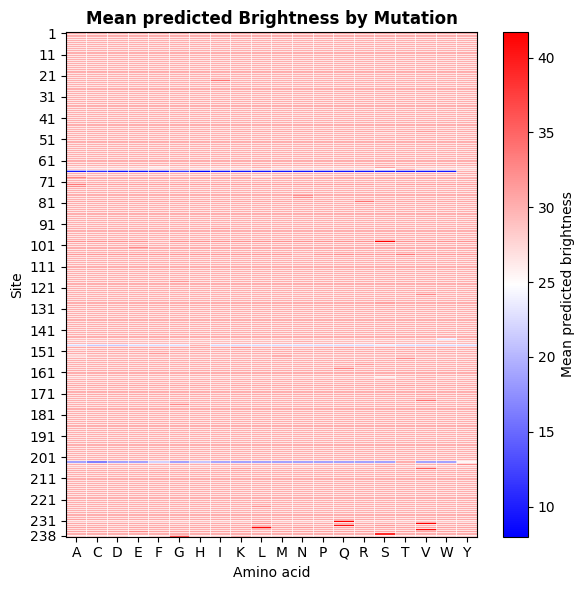

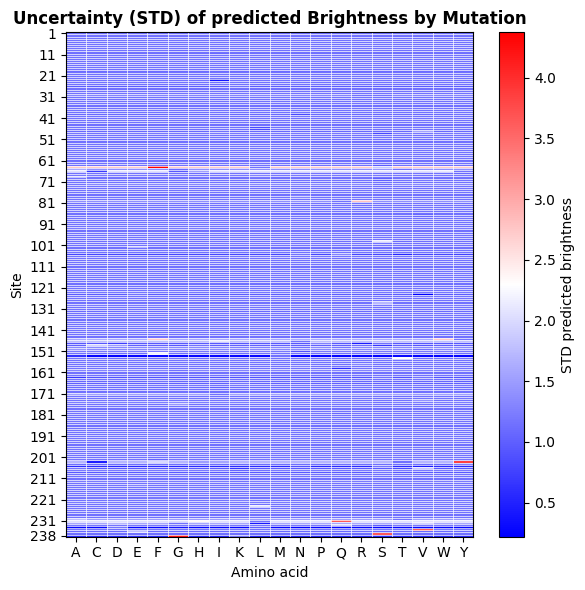

In [ ]:

#@markdown ---
#@markdown # Heatmap of Model Interrogation
#@markdown ---
# ----------------------------
# Heatmap from averaged predictions (styled)
# ----------------------------
site_order = list(range(1, template_len + 1))
df_avg = pd.DataFrame(index=site_order, columns=aa_list, dtype=float)
df_std = pd.DataFrame(index=site_order, columns=aa_list, dtype=float)

for pos0 in range(template_len):
    site = pos0 + 1
    for aa in aa_list:
        df_avg.loc[site, aa] = avg_mat[pos0, aa_to_col[aa]]
        df_std.loc[site, aa] = std_mat[pos0, aa_to_col[aa]]

print("Avg matrix shape (sites × AA):", df_avg.shape)

def plot_cellgrid_heatmap(values_df, *, aa_order, site_order, title, cbar_label):
    plt.figure(figsize=(6, 6), facecolor="white")
    ax = plt.gca()

    im = ax.imshow(values_df.values, aspect="auto", cmap="bwr", interpolation="nearest")

    # X ticks (AAs)
    ax.set_xticks(np.arange(len(aa_order)))
    ax.set_xticklabels(aa_order)

    # Y ticks every 10 rows (+ last)
    ytick_idx = np.arange(0, len(site_order), 10)
    if (len(site_order) - 1) not in ytick_idx:
        ytick_idx = np.append(ytick_idx, len(site_order) - 1)
    ax.set_yticks(ytick_idx)
    ax.set_yticklabels([site_order[i] for i in ytick_idx])

    # White boxes around each cell
    ax.set_xticks(np.arange(-0.5, len(aa_order), 1), minor=True)
    ax.set_yticks(np.arange(-0.5, len(site_order), 1), minor=True)
    ax.grid(which="minor", color="white", linestyle="-", linewidth=0.5)
    ax.tick_params(which="minor", bottom=False, left=False)

    ax.set_xlabel("Amino acid")
    ax.set_ylabel("Site")
    ax.set_title(title, fontweight="bold")

    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label(cbar_label)

    plt.tight_layout()
    plt.show()

metric_name = globals().get("var", "brightness")

# Mean heatmap (styled like your example)
plot_cellgrid_heatmap(
    df_avg,
    aa_order=aa_list,
    site_order=site_order,
    title=f"Mean predicted {metric_name.title()} by Mutation",
    cbar_label=f"Mean predicted {metric_name}"
)

# STD heatmap (same style)
plot_cellgrid_heatmap(
    df_std,
    aa_order=aa_list,
    site_order=site_order,
    title=f"Uncertainty (STD) of predicted {metric_name.title()} by Mutation",
    cbar_label=f"STD predicted {metric_name}"
)


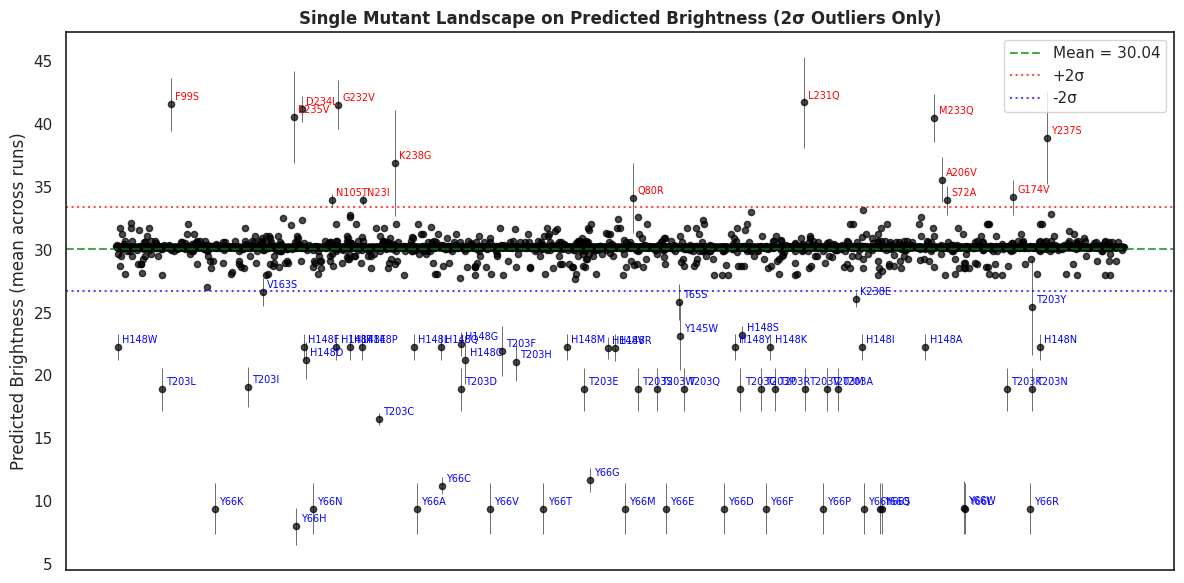

In [ ]:

#@markdown ---
#@markdown # Impact of Single Point Mutations
#@markdown ---

import numpy as np
import matplotlib.pyplot as plt

mean_dict = avg_mutant_predictions
std_dict  = std_mutant_predictions

# Build (mutation, mean, std)
records = []
for mut, mu in mean_dict.items():
    sd = std_dict.get(mut, 0.0)
    try:
        records.append((mut, float(mu), float(sd)))
    except Exception:
        pass

# Sort by mean
records.sort(key=lambda t: t[1], reverse=True)

mutations = [r[0] for r in records]
means     = np.array([r[1] for r in records])
stds      = np.array([r[2] for r in records])

# Overall stats (computed on MEANS)
mean_overall = means.mean()
std_overall  = means.std()

N = 2
upper_threshold = mean_overall + N * std_overall
lower_threshold = mean_overall - N * std_overall

# Jitter X
rng = np.random.default_rng(123)
x = rng.uniform(-0.2, 0.2, size=len(means))

# Identify outliers
is_outlier = (means > upper_threshold) | (means < lower_threshold)

plt.figure(figsize=(12, 6), facecolor='w')
ax = plt.gca()

# ---- Plot ALL points (no error bars)
ax.scatter(x, means, color='black', s=20, alpha=0.7 )

# ---- Overlay error bars ONLY on outliers (no caps)
ax.errorbar(
    x[is_outlier],
    means[is_outlier],
    yerr=stds[is_outlier],
    fmt='none',
    ecolor='black',
    elinewidth=.4,
    capsize=0
)

# ---- Annotate outliers
for xi, yi, label in zip(x[is_outlier], means[is_outlier], np.array(mutations)[is_outlier]):
    ax.annotate(
        label,
        (xi, yi),
        textcoords="offset points",
        xytext=(3, 3),
        ha='left',
        fontsize=7,
        color='red' if yi > upper_threshold else 'blue'
    )

# Threshold lines
ax.axhline(mean_overall, color='green', linestyle='--', alpha=0.7, label=f'Mean = {mean_overall:.2f}')
ax.axhline(upper_threshold, color='red', linestyle=':', alpha=0.7, label=f'+{N}σ')
ax.axhline(lower_threshold, color='blue', linestyle=':', alpha=0.7, label=f'-{N}σ')

# ---- Remove X axis completely
ax.set_xticks([])
ax.set_xlabel("")

# Labels
ax.set_ylabel(f'Predicted {var.title()} (mean across runs)')
ax.set_title(f'Single Mutant Landscape on Predicted {metric_name.title()} ({N}σ Outliers Only)', fontweight = 'bold')
ax.legend()
ax.grid(False)

plt.tight_layout()
plt.show()


In [ ]:

#@markdown ---
#@markdown #Top Sites
#@markdown ---

# Sort by mean predicted value (ascending)
sorted_items = sorted(avg_mutant_predictions.items(), key=lambda x: x[1])

lowest = sorted_items[:20]
highest = sorted_items[-20:][::-1]   # reverse so highest first

print(f"{'Highest Mutations':<20} {'Mean±SD':<14} | {'Lowest Mutations':<20} {'Mean±SD'}")
print("-" * 75)

for high, low in zip(highest, lowest):
    high_mut, high_mean = high
    low_mut, low_mean = low

    high_sd = std_mutant_predictions.get(high_mut, 0.0)
    low_sd = std_mutant_predictions.get(low_mut, 0.0)

    high_str = f"{high_mean:.2f}±{high_sd:.2f}"
    low_str  = f"{low_mean:.2f}±{low_sd:.2f}"

    print(f"{high_mut:<20} {high_str:<14} | {low_mut:<20} {low_str}")


Highest Mutations    Mean±SD        | Lowest Mutations     Mean±SD
---------------------------------------------------------------------------
L231Q                41.69±3.65     | Y66H                 7.99±1.50
F99S                 41.55±2.10     | Y66A                 9.41±2.04
G232V                41.50±1.94     | Y66D                 9.41±2.04
D234L                41.17±1.01     | Y66E                 9.41±2.04
E235V                40.53±3.66     | Y66F                 9.41±2.04
M233Q                40.45±1.88     | Y66I                 9.41±2.04
Y237S                38.89±3.65     | Y66K                 9.41±2.04
K238G                36.88±4.23     | Y66L                 9.41±2.04
A206V                35.54±1.80     | Y66M                 9.41±2.04
G174V                34.16±1.39     | Y66N                 9.41±2.04
Q80R                 34.11±2.80     | Y66P                 9.41±2.04
N23I                 33.93±0.38     | Y66Q                 9.41±2.04
S72A                 33.91±1.

In [ ]:
#@markdown ---
#@markdown # Random Forest Greedy Design — local output (no Drive mount)
#@markdown ---

import os
import datetime
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# ----------------------------
# Design controls
# ----------------------------

#@markdown **Objective**
MAXIMIZE = True  #@param {type:"boolean"}

#@markdown **Greedy acceptance threshold**
STEP_THRESHOLD = 5.0  #@param {type:"number"}

#@markdown **Design controls**
N_DESIGNS = 10        #@param {type:"integer"}
MAX_MUTATIONS = 25    #@param {type:"integer"}
AVOID_REPEAT_POS = False  #@param {type:"boolean"}

#@markdown **Write a multi-FASTA locally**
WRITE_FASTA = True  #@param {type:"boolean"}
MULTIFASTA_BASENAME = "ALL_DESIGNS_RF_GREEDY"  #@param {type:"string"}

# ----------------------------
# RF training params
# ----------------------------
TEST_SIZE = 0.2       #@param {type:"number"}
N_ESTIMATORS = 300    #@param {type:"integer"}
RF_N_JOBS = -1

# ----------------------------
# One-hot params
# ----------------------------
aa_alphabet = "ACDEFGHIKLMNPQRSTVWY"
aa_index = {aa: i for i, aa in enumerate(aa_alphabet)}
aa_list = list(aa_alphabet)

# Use your notebook vars (must already exist in the notebook)
template_seq = template
template_name_local = template_name  # avoid accidental shadowing
template_len = len(template_seq)

# Ensure encoding length can hold the template
max_len = max(238, template_len)

def one_hot_encode(seq: str, max_len: int) -> np.ndarray:
    """Flattened one-hot, padded/truncated to max_len."""
    arr = np.zeros((max_len, len(aa_alphabet)), dtype=np.float32)
    for i, aa in enumerate(seq[:max_len]):
        idx = aa_index.get(aa)
        if idx is not None:
            arr[i, idx] = 1.0
    return arr.reshape(-1)

def predict_seq_rf(model: RandomForestRegressor, seq: str) -> float:
    x = one_hot_encode(seq, max_len).reshape(1, -1)
    return float(model.predict(x)[0])

def wrap_fasta(seq: str, width: int = 60) -> str:
    return "\n".join(seq[i:i+width] for i in range(0, len(seq), width))

# ----------------------------
# Build dataset from `proteins` using `var` (ONCE)
# ----------------------------
seqs, vals = [], []
for entry in proteins:
    seq = entry.get("seq")
    if not seq:
        continue

    if var == "stokes_shift":
        val = entry.get("stokes_shift", None)
        if val is None:
            states = entry.get("states", [])
            val = states[0].get("stokes_shift") if (states and isinstance(states, list)) else None
    else:
        states = entry.get("states", [])
        val = states[0].get(var) if (states and isinstance(states, list)) else None

    if val is None:
        continue

    try:
        seqs.append(seq)
        vals.append(float(val))
    except Exception:
        pass

if not seqs:
    raise RuntimeError(f"No usable samples found for var={var!r}. Check property availability.")

print(f"Total usable sequences: {len(seqs)} | target: {var}")

X_full = np.stack([one_hot_encode(s, max_len) for s in seqs]).astype(np.float32)
y_full = np.array(vals, dtype=np.float32)

# ----------------------------
# Output setup (local folder)
# ----------------------------
OUT_DIR = "designed_seqs_rf_greedy"
if bool(WRITE_FASTA):
    os.makedirs(OUT_DIR, exist_ok=True)

timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
multifasta_path = None
fh_multi = None
if bool(WRITE_FASTA):
    multifasta_path = os.path.join(OUT_DIR, f"{MULTIFASTA_BASENAME}_{var}.fasta")
    fh_multi = open(multifasta_path, "w", encoding="utf-8")

# ----------------------------
# Directed evolution (ONE pass, accept per position)
# ----------------------------
def directed_evolution_one(design_idx: int, model: RandomForestRegressor):
    """
    One greedy trajectory using the provided RF model.
    Returns:
      (final_seq, final_pred, mutations_applied, all_mutation_log)
    """
    current_seq = template_seq
    current_pred = float(predict_seq_rf(model, current_seq))

    mutations_applied = []
    all_mutation_log = []
    used_positions = set()
    step_counter = 0

    print(f"\nStarting {var.title()}: {current_pred:.2f}")

    for pos in range(len(current_seq)):
        # Enforce mutation cap
        if int(MAX_MUTATIONS) > 0 and len(mutations_applied) >= int(MAX_MUTATIONS):
            break

        if bool(AVOID_REPEAT_POS) and (pos in used_positions):
            step_counter += 1
            continue

        original_aa = current_seq[pos]
        best_pred = current_pred
        best_mutation = None
        best_seq = current_seq

        for new_aa in aa_list:
            if new_aa == original_aa:
                continue

            mutated_seq = current_seq[:pos] + new_aa + current_seq[pos+1:]
            pred = float(predict_seq_rf(model, mutated_seq))

            all_mutation_log.append({
                "mutation": f"{original_aa}{pos + 1}{new_aa}",
                "predicted": pred,
                "accepted": False,
                "step": step_counter
            })

            if bool(MAXIMIZE):
                if pred > best_pred + float(STEP_THRESHOLD):
                    best_pred = pred
                    best_mutation = f"{original_aa}{pos + 1}{new_aa}"
                    best_seq = mutated_seq
            else:
                if pred < best_pred - float(STEP_THRESHOLD):
                    best_pred = pred
                    best_mutation = f"{original_aa}{pos + 1}{new_aa}"
                    best_seq = mutated_seq

        applied = False
        if bool(MAXIMIZE) and (best_pred > current_pred + float(STEP_THRESHOLD)):
            applied = True
        if (not bool(MAXIMIZE)) and (best_pred < current_pred - float(STEP_THRESHOLD)):
            applied = True

        if applied and (best_mutation is not None):
            current_seq = best_seq
            current_pred = float(best_pred)
            mutations_applied.append(best_mutation)
            used_positions.add(pos)

            # mark accepted for this step
            for log in reversed(all_mutation_log):
                if log["step"] == step_counter and log["mutation"] == best_mutation:
                    log["accepted"] = True
                    break

            print(f"Applied {best_mutation}: {var.title()} = {current_pred:.2f}")

        step_counter += 1

    return current_seq, float(current_pred), mutations_applied, all_mutation_log

# ----------------------------
# Generate N designs:
#   - NEW train/test split per design
#   - NEW RF trained per design
#   - baseline computed per design (since model differs)
#   - prints screenshot-style output
#   - writes multi-FASTA locally
# ----------------------------
DESIGNS = []  # optional: keep for downstream characterization

try:
    for i in range(1, int(N_DESIGNS) + 1):
        # Train/test split PER DESIGN
        X_train, X_test, y_train, y_test = train_test_split(
            X_full, y_full, test_size=float(TEST_SIZE), random_state=None
        )

        rf = RandomForestRegressor(
            n_estimators=int(N_ESTIMATORS),
            random_state=None,
            n_jobs=int(RF_N_JOBS)
        )
        rf.fit(X_train, y_train)

        # Evaluate this RF
        y_pred = rf.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        baseline_pred = predict_seq_rf(rf, template_seq)

        print(f"\nRF eval: MAE={mae:.2f} | R²={r2:.2f}")
        print(f"Template ({template_name_local}) predicted {var}: {baseline_pred:.6f}")

        # Write template ONCE at top of FASTA (first design only)
        if bool(WRITE_FASTA) and fh_multi is not None and i == 1:
            fh_multi.write(f">TEMPLATE_{template_name_local}_{var}_pred={baseline_pred:.6f}\n")
            fh_multi.write(wrap_fasta(template_seq) + "\n")

        # Run greedy trajectory with this model
        seq_i, pred_i, muts_i, all_mut_log = directed_evolution_one(design_idx=i, model=rf)

        delta_vs_template = float(pred_i - baseline_pred)
        header = (
            f">Design_{i:03d}_{template_name_local}_{var}"
            f"_pred={pred_i:.6f}"
            f"_delta_vs_template={delta_vs_template:+.6f}"
            f"_nmut={len(muts_i)}"
            f"_stepthr={float(STEP_THRESHOLD):g}"
            f"_maximize={bool(MAXIMIZE)}"
            f"_mae={mae:.3f}"
            f"_r2={r2:.3f}"
        )

        # Screenshot-style block
        print(f"\n{header}")
        print(f"Mutations: {', '.join(muts_i) if muts_i else '(none)'}")
        print(wrap_fasta(seq_i))

        # Save for downstream characterization cell
        DESIGNS.append({"id": i, "seq": seq_i, "muts": muts_i, "pred": pred_i})

        if bool(WRITE_FASTA) and fh_multi is not None:
            fh_multi.write(header + "\n")
            fh_multi.write(wrap_fasta(seq_i) + "\n")

finally:
    if fh_multi is not None:
        fh_multi.close()

if bool(WRITE_FASTA):
    print(f"\nMulti-FASTA written locally to:\n  {multifasta_path}")
    print(f"Folder: {OUT_DIR}/")


Total usable sequences: 148 | target: brightness

RF eval: MAE=11.27 | R²=0.69
Template (EGFP) predicted brightness: 30.826301

Starting Brightness: 30.83
Applied F99S: Brightness = 39.06
Applied L231Q: Brightness = 48.37
Applied G232V: Brightness = 56.90
Applied M233Q: Brightness = 65.69
Applied D234L: Brightness = 77.83
Applied E235V: Brightness = 88.93
Applied L236E: Brightness = 94.09
Applied Y237S: Brightness = 101.43
Applied K238G: Brightness = 110.50

>Design_001_EGFP_brightness_pred=110.503563_delta_vs_template=+79.677262_nmut=9_stepthr=5_maximize=True_mae=11.268_r2=0.694
Mutations: F99S, L231Q, G232V, M233Q, D234L, E235V, L236E, Y237S, K238G
MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTL
VTTLTYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTISFKDDGNYKTRAEVKFEGDTLV
NRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLAD
HYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITQVQLVESG

RF eval: MAE=10.95 | R²=0.52
Template (EGFP) predicted brightness: 31.384067

Starting Brightness:

In [ ]:
#@markdown ---
#@markdown # Download Dependencies to Generate MSA
#@markdown ---


RUN_INSTALL = True
if RUN_INSTALL:
    print("Downloading dependencies...\n")

    from tqdm.auto import tqdm
    import subprocess

    steps = [
        ["apt-get", "-qq", "update"],
        ["apt-get", "-qq", "install", "-y", "mafft"],
        ["pip", "-q", "install", "pymsaviz"],
        ["pip", "-q", "install", "biopython"],
    ]

    with tqdm(
        total=len(steps),
        desc="",
        bar_format="{bar} {n_fmt}/{total_fmt}",
        colour="cyan",
    ) as pbar:
        for cmd in steps:
            subprocess.run(cmd, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL, check=True)
            pbar.update(1)


In [ ]:
#@markdown ---
#@markdown # Run MAFFT MSA on the multi-FASTA
#@markdown ---

import os
import subprocess
from datetime import datetime
import tempfile
from collections import Counter

from Bio import SeqIO, AlignIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq

try:
    from pymsaviz import MsaViz
except ImportError:
    MsaViz = None

from IPython.display import SVG, display


#@markdown ---
#@markdown ## Inputs / Outputs
#@markdown ---
INPUT_FASTA = multifasta_path  #@param {type:"string"}
OUTDIR = "msa_outputs"         #@param {type:"string"}

#@markdown ---
#@markdown ## Visualization
#@markdown ---
WRAP_LENGTH = 90               #@param {type:"integer"}
CONSENSUS_THRESHOLD = 0.501    #@param {type:"number"}
MAKE_SVG = True                #@param {type:"boolean"}

# Always do U->X; do NOT use --anysymbol
REPLACE_U_WITH_X = True
USE_ANY_SYMBOL = False


def consensus_from_alignment(msa, threshold=0.501, gap_char="-"):
    L = msa.get_alignment_length()
    out = []
    for col in range(L):
        syms = [rec.seq[col] for rec in msa]
        non_gaps = [c for c in syms if c != gap_char]
        if not non_gaps:
            out.append(gap_char)
            continue
        counts = Counter(non_gaps)
        top, n = counts.most_common(1)[0]
        out.append(top if (n / len(non_gaps)) >= threshold else "X")
    return "".join(out)


def run_basic_msa(input_fasta_path: str, output_dir: str):
    os.makedirs(output_dir, exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    with tempfile.TemporaryDirectory() as tmpdir:
        cleaned_fasta = os.path.join(tmpdir, "cleaned.fasta")
        aligned_fasta = os.path.join(tmpdir, "aligned.fasta")

        # Clean FASTA (U->X, strip non-AA)
        cleaned = []
        allowed = set("ACDEFGHIKLMNPQRSTVWYXBZJO-")  # exclude U because we replace it

        for rec in SeqIO.parse(input_fasta_path, "fasta"):
            seq = str(rec.seq).upper()
            if REPLACE_U_WITH_X:
                seq = seq.replace("U", "X")
            seq = "".join(c for c in seq if c in allowed)
            if seq:
                cleaned.append(SeqRecord(Seq(seq), id=rec.id[:50], description=""))

        SeqIO.write(cleaned, cleaned_fasta, "fasta")

        # MAFFT
        mafft = ["mafft", "--auto", cleaned_fasta]
        proc = subprocess.run(mafft, capture_output=True, text=True)
        if proc.returncode != 0:
            raise RuntimeError(proc.stderr or "MAFFT failed (no stderr)")

        with open(aligned_fasta, "w", encoding="utf-8") as f:
            f.write(proc.stdout)

        alignment = AlignIO.read(aligned_fasta, "fasta")
        consensus = consensus_from_alignment(alignment, float(CONSENSUS_THRESHOLD))

        aln_out = os.path.join(output_dir, f"aligned_{timestamp}.fasta")
        con_out = os.path.join(output_dir, f"consensus_{timestamp}.txt")
        AlignIO.write(alignment, aln_out, "fasta")
        with open(con_out, "w", encoding="utf-8") as f:
            f.write(consensus + "\n")

        if MAKE_SVG and MsaViz is not None:
            svg_path = os.path.join(output_dir, f"msa_{timestamp}.svg")
            viz = MsaViz(
                aln_out,
                wrap_length=int(WRAP_LENGTH),
                show_label=True,
                show_count=True,
                show_consensus=True,
                color_scheme="Identity",
            )
            viz.savefig(svg_path)
            display(SVG(filename=svg_path))


# Run
run_basic_msa(INPUT_FASTA, OUTDIR)


In [ ]:
#@markdown ---
#@markdown # RF Characterization of Designeded Sequences
#@markdown *Characterizes Across Parameters (Ex_Max, Brightness, Stokes_Shift, Em_Max)*
#@markdown ---


# ============================================================
# RF Characterization of Each Designed Sequence (Single Cell)
# Plot style: white bars + small error bars + blue/orange squares + stats bracket
# ============================================================

import re
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

# stats (between Template vs Design predictions across runs)
from scipy.stats import ttest_ind


# ----------------------------
# Sanity
# ----------------------------
if "DESIGNS" not in globals() or not DESIGNS:
    raise RuntimeError(
        "DESIGNS not found. In your design loop, store outputs using:\n"
        "DESIGNS.append({'id': i, 'seq': seq_i, 'muts': muts_i, 'pred': pred_i})"
    )

# ----------------------------
# Encoding helpers
# ----------------------------
max_len = 238
aa_alphabet = "ACDEFGHIKLMNPQRSTVWY"
aa_index = {aa: i for i, aa in enumerate(aa_alphabet)}

def one_hot_encode(seq, max_len=max_len):
    arr = np.zeros((max_len, len(aa_alphabet)), dtype=np.float32)
    for i, aa in enumerate(seq[:max_len]):
        j = aa_index.get(aa)
        if j is not None:
            arr[i, j] = 1.0
    return arr.flatten()

def parse_mutation(m):
    m = m.strip()
    match = re.match(r"^([A-Z])(\d+)([A-Z])$", m)
    if not match:
        raise ValueError(f"Bad mutation: {m}")
    _, pos, new = match.groups()
    return int(pos), new

def apply_mutations(seq, muts):
    s = list(seq)
    for pos1, aa in muts:
        if 1 <= pos1 <= len(s):
            s[pos1 - 1] = aa
    return "".join(s)

def get_value(entry, var):
    states = entry.get("states", []) or []

    if var == "stokes_shift":
        v = entry.get("stokes_shift", None)
        if v is not None:
            return v
        if states:
            v = states[0].get("stokes_shift", None)
            if v is not None:
                return v
            ex = states[0].get("ex_max")
            em = states[0].get("em_max")
            if ex is not None and em is not None:
                try:
                    return float(em) - float(ex)
                except Exception:
                    return None
        return None

    if states:
        return states[0].get(var, None)
    return None

# ----------------------------
# Plot helpers (style like your example)
# ----------------------------
def sem(x):
    x = np.asarray(x, dtype=float)
    if len(x) <= 1:
        return 0.0
    return float(np.std(x, ddof=1) / np.sqrt(len(x)))

def p_to_stars(p):
    if p < 1e-4:
        return "****"
    if p < 1e-3:
        return "***"
    if p < 1e-2:
        return "**"
    if p < 0.05:
        return "*"
    return "ns"

def add_sig_bracket(ax, x1, x2, y, h, text, lw=2):
    # bracket
    ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y],
            lw=lw, c="black", clip_on=False)
    ax.text((x1 + x2) / 2, y + h, text,
            ha="center", va="bottom", fontsize=14, color="black")

# ----------------------------
# Controls
# ----------------------------
vars_to_test = ["ex_max", "em_max", "stokes_shift", "brightness"]
n_runs = 3

template_seq = template  # must exist
if "template_name" not in globals():
    template_name = "template"

# ============================================================
# MAIN
# ============================================================
for design in DESIGNS:
    did = int(design["id"])
    designed_seq = design["seq"]
    mutations_applied = design.get("muts", []) or []

    print("\n" + "=" * 80)
    print(f"Design {did:03d}")
    print(f"Mutations: {', '.join(mutations_applied) if mutations_applied else '(none)'}")

    # reconstruction check (only if muts exist)
    if mutations_applied:
        try:
            parsed = [parse_mutation(m) for m in mutations_applied]
            recon = apply_mutations(template_seq, parsed)
            if recon != designed_seq:
                print("WARNING: reconstructed sequence != designed sequence")
        except Exception as e:
            print("Mutation parse warning:", e)

    for var in vars_to_test:
        seqs, vals = [], []
        for p in proteins:
            seq = p.get("seq")
            v = get_value(p, var)
            if seq and v is not None:
                try:
                    seqs.append(seq)
                    vals.append(float(v))
                except Exception:
                    pass

        if len(seqs) < 30:
            print(f"{var}: insufficient data")
            continue

        X_full = np.array([one_hot_encode(s) for s in seqs], dtype=np.float32)
        y_full = np.array(vals, dtype=np.float32)

        template_preds = []
        mutant_preds = []

        for run in range(n_runs):
            Xtr, Xte, ytr, yte = train_test_split(X_full, y_full, test_size=0.2)

            model = RandomForestRegressor(n_estimators=100)
            model.fit(Xtr, ytr)

            mae = mean_absolute_error(yte, model.predict(Xte))
            r2 = r2_score(yte, model.predict(Xte))
            print(f"Design {did:03d} | Run {run+1:02d} {var}: MAE={mae:.2f} R²={r2:.2f}")

            t_enc = one_hot_encode(template_seq).reshape(1, -1)
            m_enc = one_hot_encode(designed_seq).reshape(1, -1)

            template_preds.append(float(model.predict(t_enc)[0]))
            mutant_preds.append(float(model.predict(m_enc)[0]))

        # ---------------- plot (match your example) ----------------
        labels = ["Template", f"Design {did:03d}"]
        means = [float(np.mean(template_preds)), float(np.mean(mutant_preds))]
        errs  = [sem(template_preds), sem(mutant_preds)]

        # stats across runs (Template vs Design)
        tstat, pval = ttest_ind(template_preds, mutant_preds, equal_var=False)
        stars = p_to_stars(float(pval))

        plt.figure(figsize=(2.5, 3))
        ax = plt.gca()

        x = np.arange(2)

        # white bars w/ black edge + small error bars
        bars = ax.bar(
            x, means,
            yerr=errs,
            capsize=4,
            edgecolor="black",
            linewidth=3,
            color="white",
            zorder=2
        )

        # overlay squares (blue for template, orange for design)
        jitter = 0.20
        x0 = np.full(len(template_preds), x[0]) + np.random.uniform(-jitter, jitter, len(template_preds))
        x1 = np.full(len(mutant_preds),   x[1]) + np.random.uniform(-jitter, jitter, len(mutant_preds))

        ax.scatter(x0, template_preds, marker="s", s=90, alpha = 0.8, c="#4C72B0",
                   edgecolors="black", linewidths = 0.5, zorder=3)
        ax.scatter(x1, mutant_preds, marker="s", s=90, alpha = 0.8, c="#DD8452",
                   edgecolors="black", linewidths=0.5, zorder=3)

        # annotate mean values (like your figure)
        for xi, m in zip(x, means):
            ax.text(xi, m * 1.03, f"{m:.2f}", ha="center", va="bottom", fontsize=12)

        # significance bracket
        ymax = max([max(template_preds), max(mutant_preds), max(means)]) if (template_preds and mutant_preds) else max(means)
        h = max(0.05 * ymax, 1e-6)
        y = ymax + 6 * h
        add_sig_bracket(ax, x[0], x[1], y, h, stars)

        ax.set_xticks(x)
        ax.set_xticklabels(labels, fontsize=10)
        ax.set_ylabel(f"Predicted {var.title()}", fontsize=10)
        ax.set_title(f"Predicted {var.title()}", fontsize=18, pad=15)

        # cleaner look (similar to your image)
        ax.axhline(0, color="black", linewidth=3)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_linewidth(4)
        ax.spines["bottom"].set_linewidth(4)
        ax.tick_params(axis="x", width=4, length=8, labelsize=10, labelrotation = 45)
        ax.tick_params(axis="y", width=4, length=10, labelsize=12)
        ax.set_ylim(0, y + 3 * h)
        plt.tight_layout()
        plt.show()

        print(f"Total usable sequences: {len(seqs)}")
        print(f"Applied mutations: {mutations_applied}")
        print(f"Stats (Template vs Design): t={tstat:.3f} p={pval:.3e} ({stars})")


In [ ]:
#@markdown ---
#@markdown # Characterize across Parameters
#@markdown ---
import time
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from Bio import SeqIO

# ----------------------------
# One-hot encoding
# ----------------------------
max_len = 238
aa_alphabet = "ACDEFGHIKLMNPQRSTVWY"
aa_index = {aa: i for i, aa in enumerate(aa_alphabet)}

def one_hot_encode(seq: str, max_len: int = max_len) -> np.ndarray:
    arr = np.zeros((max_len, len(aa_alphabet)), dtype=np.float32)
    for i, aa in enumerate(seq[:max_len]):
        j = aa_index.get(aa)
        if j is not None:
            arr[i, j] = 1.0
    return arr.flatten()

# ----------------------------
# Utilities
# ----------------------------
def compute_stokes_shift_from_states(states):
    if not states or not isinstance(states, list):
        return None
    s0 = states[0] if states else None
    if not isinstance(s0, dict):
        return None
    ex = s0.get("ex_max", None)
    em = s0.get("em_max", None)
    if ex is None or em is None:
        return None
    try:
        return float(em) - float(ex)
    except Exception:
        return None

def get_value(entry_dict: dict, var: str):
    """
    Pull target value from FPbase entry:
      - for stokes_shift: prefer entry_dict['stokes_shift'] if present, else compute from states[0]
      - else: use states[0][var]
    """
    if var == "stokes_shift":
        v = entry_dict.get("stokes_shift", None)
        if v is not None:
            try:
                return float(v)
            except Exception:
                return None
        return compute_stokes_shift_from_states(entry_dict.get("states", None))

    states = entry_dict.get("states", [])
    if states and isinstance(states, list) and isinstance(states[0], dict):
        v = states[0].get(var, None)
        if v is None:
            return None
        try:
            return float(v)
        except Exception:
            return None
    return None

def get_mutations(template_seq: str, mutant_seq: str):
    """
    Return mutation strings like A23G for all positions where mutant differs.
    Uses 1-indexed positions. Only compares up to min length; reports length mismatch if present.
    """
    muts = []
    L = min(len(template_seq), len(mutant_seq))
    for i, (t_aa, m_aa) in enumerate(zip(template_seq[:L], mutant_seq[:L]), start=1):
        if t_aa != m_aa:
            muts.append(f"{t_aa}{i}{m_aa}")

    if len(template_seq) != len(mutant_seq):
        muts.append(f"LEN{len(template_seq)}->{len(mutant_seq)}")

    return muts

# ----------------------------
# Main analysis
# ----------------------------
def analyze_fasta_file(fasta_path: str, proteins: list, n_runs: int = 10,
                      vars_to_test=None, test_size: float = 0.2,
                      n_estimators: int = 100, n_jobs: int = -1,
                      random_state=None) -> pd.DataFrame:
    """
    Reads a multi-FASTA:
      - record[0] = template
      - record[1:] = designs/mutants

    For each mutant, for each property var in vars_to_test:
      - repeats n_runs times:
        - build dataset from proteins (fresh train/test split each run)
        - train RF
        - predict template and mutant
      - stores mean mutant prediction and delta vs mean template prediction
      - stores full per-run template predictions (so you can later compute error bars/stats)

    Returns a DataFrame with one row per mutant.
    """
    if vars_to_test is None:
        vars_to_test = ["ex_max", "em_max", "stokes_shift", "brightness"]

    records = list(SeqIO.parse(fasta_path, "fasta"))
    if len(records) < 2:
        raise RuntimeError("FASTA must contain at least a template record and one mutant record.")

    template_seq = str(records[0].seq).upper()
    template_name = records[0].id

    print(f"Loaded FASTA: {fasta_path}")
    print(f"Template: {template_name} (length {len(template_seq)})")
    print(f"Mutants: {len(records) - 1}")
    print(f"Runs per property: {n_runs}")

    results = []

    for rec_idx, mutant_rec in enumerate(records[1:], start=1):
        mutant_seq = str(mutant_rec.seq).upper()
        mutant_name = mutant_rec.id

        print("-" * 80)
        print(f"Analyzing mutant {rec_idx:03d}: {mutant_name} (length {len(mutant_seq)})")

        row = {
            "template_name": template_name,
            "mutant_name": mutant_name,
            "mutations": ", ".join(get_mutations(template_seq, mutant_seq)) or "None",
        }

        for var in vars_to_test:
            template_preds = []
            mutant_preds = []

            t0 = time.time()

            # Build dataset ONCE per var (then resplit each run)
            seqs, vals = [], []
            for entry_dict in proteins:
                seq = entry_dict.get("seq", None)
                if not seq:
                    continue
                v = get_value(entry_dict, var)
                if v is None:
                    continue
                seqs.append(seq)
                vals.append(v)

            if len(seqs) < 30:
                print(f"{var}: insufficient data (n={len(seqs)})")
                row[f"mean_{var}"] = np.nan
                row[f"delta_{var}"] = np.nan
                row[f"{var}_template_preds"] = []
                row[f"{var}_mutant_preds"] = []
                continue

            X = np.array([one_hot_encode(s, max_len) for s in seqs], dtype=np.float32)
            y = np.array(vals, dtype=np.float32)

            # Encode template/mutant once
            template_encoded = one_hot_encode(template_seq, max_len).reshape(1, -1)
            mutant_encoded = one_hot_encode(mutant_seq, max_len).reshape(1, -1)

            for run in range(n_runs):
                X_train, X_test, y_train, y_test = train_test_split(
                    X, y, test_size=float(test_size), random_state=None
                )

                model = RandomForestRegressor(
                    n_estimators=int(n_estimators),
                    n_jobs=int(n_jobs),
                    random_state=None
                )
                model.fit(X_train, y_train)

                template_pred = float(model.predict(template_encoded)[0])
                mutant_pred = float(model.predict(mutant_encoded)[0])

                template_preds.append(template_pred)
                mutant_preds.append(mutant_pred)

            mean_template = float(np.mean(template_preds))
            mean_mutant = float(np.mean(mutant_preds))
            delta = float(mean_mutant - mean_template)

            row[f"mean_{var}"] = mean_mutant
            row[f"delta_{var}"] = delta
            row[f"{var}_template_preds"] = template_preds
            row[f"{var}_mutant_preds"] = mutant_preds

            dt = time.time() - t0
            print(f"{var}: delta={delta:.3f}, mutant_mean={mean_mutant:.3f}, time={dt:.2f}s, n={len(seqs)}")

        results.append(row)
        print(f"Finished mutant {rec_idx:03d}: {mutant_name}")

    df_results = pd.DataFrame(results)
    print("-" * 80)
    print("Final Results (head):")
    # print(df_results.head())
    return df_results

# Example usage:
df_results = analyze_fasta_file(multifasta_path, proteins, n_runs=3)
df_results.to_csv("rf_design_characterization.csv", index=False)


In [ ]:
#@markdown ---
#@markdown # Visualize Plots
#@markdown ---

import ast
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, ScalarFormatter

# ----------------------------
# Pick your results DF
# ----------------------------
if "df_results" in globals():
    _df = df_results
elif "df" in globals():
    _df = df
else:
    raise RuntimeError("Neither df_results nor df found. Run your analyze_fasta_file(...) cell first.")

# ----------------------------
# Mean columns for plotting
# ----------------------------
numeric_cols = [c for c in _df.columns if c.startswith("mean_")]
if not numeric_cols:
    raise RuntimeError("No mean_* columns found in your results dataframe.")

df_plot = _df[numeric_cols].copy()
for c in numeric_cols:
    df_plot[c] = pd.to_numeric(df_plot[c], errors="coerce")

# Round wavelength columns to integers (prevents decimal tick labels)
for c in ["mean_ex_max", "mean_em_max"]:
    if c in df_plot.columns:
        df_plot[c] = df_plot[c].round(0)

df_plot = df_plot.dropna(how="all")
if df_plot.shape[0] < 2:
    raise RuntimeError("Not enough rows with mean_* values to make a pairplot.")

# ----------------------------
# Helper: parse list-like (if saved to CSV then reloaded)
# ----------------------------
def as_list(x):
    if isinstance(x, list):
        return x
    if isinstance(x, tuple):
        return list(x)
    if isinstance(x, str):
        try:
            v = ast.literal_eval(x.strip())
            return v if isinstance(v, list) else []
        except Exception:
            return []
    return []

# ----------------------------
# Extract template prediction distributions (from first row)
# ----------------------------
template_kdes = {}
first_row = _df.index[0]

for var in ["ex_max", "em_max", "stokes_shift", "brightness"]:
    col_name = f"{var}_template_preds"
    mean_name = f"mean_{var}"
    if col_name in _df.columns and mean_name in df_plot.columns:
        preds = as_list(_df.at[first_row, col_name])
        clean = []
        for p in preds:
            try:
                fp = float(p)
                if np.isfinite(fp):
                    clean.append(fp)
            except Exception:
                pass
        if len(clean) > 1:
            template_kdes[mean_name] = clean

# ----------------------------
# Pairplot style
# ----------------------------
plt.style.use("default")
sns.set_style("white")
sns.set_context("notebook")

g = sns.pairplot(
    df_plot,
    kind="scatter",
    diag_kind="kde",
    plot_kws={"alpha": 0.7, "s": 60}
)

g.fig.suptitle(
    "Scatter Matrix of Predicted Mean Values using EGFP as Template",
    fontsize=16,
    y=1.02
)

# Overlay template KDEs on diagonal
for i, col in enumerate(df_plot.columns):
    if col in template_kdes:
        ax = g.diag_axes[i]
        sns.kdeplot(
            template_kdes[col],
            fill=True,
            color="red",
            alpha=0.3,
            label="Template",
            ax=ax
        )
        ax.legend(loc="upper right", fontsize=6.5)

# ----------------------------
# Ticks: majors + manual minors (NO AutoMinorLocator)
# ----------------------------
plain = ScalarFormatter(useOffset=False)
plain.set_scientific(False)

def add_minor_ticks(ax, axis="x", n_minor=3):
    """
    Add evenly-spaced minor ticks between major ticks.
    n_minor = number of subdivisions per major interval (3 => 2 minors between majors).
    """
    if axis == "x":
        majors = ax.get_xticks()
        if len(majors) < 2:
            return
        minors = []
        for a, b in zip(majors[:-1], majors[1:]):
            step = (b - a) / float(n_minor)
            for k in range(1, n_minor):
                minors.append(a + k * step)
        ax.set_xticks(minors, minor=True)
    else:
        majors = ax.get_yticks()
        if len(majors) < 2:
            return
        minors = []
        for a, b in zip(majors[:-1], majors[1:]):
            step = (b - a) / float(n_minor)
            for k in range(1, n_minor):
                minors.append(a + k * step)
        ax.set_yticks(minors, minor=True)

# Apply tick styling to all axes
for ax_row in g.axes:
    for ax in ax_row:
        if ax is None:
            continue

        # ensure tick marks draw (seaborn/mpl sometimes hides them)
        ax.tick_params(axis="both", which="both",
                       bottom=True, left=True, top=False, right=False,
                       direction="out")
        ax.xaxis.set_ticks_position("bottom")
        ax.yaxis.set_ticks_position("left")

        # ~5 major ticks
        ax.xaxis.set_major_locator(MaxNLocator(5))
        ax.yaxis.set_major_locator(MaxNLocator(5))

        # plain number formatting
        ax.xaxis.set_major_formatter(plain)
        ax.yaxis.set_major_formatter(plain)

        # force major ticks to be computed, then place minor ticks between them
        ax.figure.canvas.draw_idle()
        add_minor_ticks(ax, "x", n_minor=3)
        add_minor_ticks(ax, "y", n_minor=3)

        # tick mark sizes
        ax.tick_params(axis="both", which="major", length=6, width=1.2, labelsize=10)
        ax.tick_params(axis="both", which="minor", length=3, width=0.9)

        for label in ax.get_xticklabels():
            label.set_rotation(0)

# Force integer ticks for wavelength axes (ex/em) across row/col + diagonal
int_cols = [c for c in ["mean_ex_max", "mean_em_max"] if c in df_plot.columns]
col_to_idx = {c: i for i, c in enumerate(df_plot.columns)}
int_loc = MaxNLocator(5, integer=True)

for c in int_cols:
    j = col_to_idx[c]

    # column j => y-axis
    for ax in g.axes[:, j]:
        if ax is None:
            continue
        ax.yaxis.set_major_locator(int_loc)
        ax.figure.canvas.draw_idle()
        add_minor_ticks(ax, "y", n_minor=3)

    # row j => x-axis
    for ax in g.axes[j, :]:
        if ax is None:
            continue
        ax.xaxis.set_major_locator(int_loc)
        ax.figure.canvas.draw_idle()
        add_minor_ticks(ax, "x", n_minor=3)

    # diagonal x-axis
    diag_ax = g.diag_axes[j]
    if diag_ax is not None:
        diag_ax.xaxis.set_major_locator(int_loc)
        diag_ax.figure.canvas.draw_idle()
        add_minor_ticks(diag_ax, "x", n_minor=3)

plt.tight_layout()
plt.show()
